In [158]:
#!pip install pycalphad

In [ ]:
#import os
#os.environ["REPOSITORY_URL"] = 'https://raw.githubusercontent.com/pyracetamol/tmms_2025/refs/heads/main/pycalphad'

In [160]:
#!wget -O Cr-Fe-Ni.tdb "$REPOSITORY_URL/Cr-Fe-Ni.tdb"
#!wget -O Fe-C.TDB "$REPOSITORY_URL/Fe-C.TDB"

# Introduction to PyCalphad

This short introduction will walk you through the basic steps of using PyCalphad (and Python-based scientific software in general).

In Python, we often need to import additional libraries that extend the core functionality of the language. These libraries act as toolkits for specific tasks—in our case, thermodynamic calculations with PyCalphad.

At the beginning of any new session, you should run the import statements shown below. You can copy them exactly as they are. If the commands execute without any errors, your installation of PyCalphad has been successful.

In [161]:
from pycalphad import Database, calculate, equilibrium, variables as v, Model, binplot

# Only needed in a Jupyter Notebook
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt 
matplotlib.style.use('fast')     # Optional plot styling

import numpy as np

Matplotlib enables the creation of plots and visualizations in Python. It supports a wide range of plot types and offers extensive customization options for figures, making it a powerful tool for presenting data visually.

NumPy provides efficient tools for numerical computing, including arrays, mathematical functions, and linear algebra operations. It simplifies and accelerates numerical calculations in Python.

In [162]:
# Some utility functions

def print_constituents(phase_name, db):
    constituents = db.phases[phase_name].constituents
    print(f"Constituents for phase '{phase_name}':")
    for i, sublattice in enumerate(constituents):
        species_names = [sp.name for sp in sublattice]
        print(f"\tSublattice {i+1}: {', '.join(species_names)}")


def summarize_equilibrium_result(eq):
    """
    Print a complete summary of a PyCalphad equilibrium() result.
    Handles single-condition grids and prints:
      - Conditions
      - Total Gibbs energy
      - Phases
      - Phase amounts
      - Compositions (X)
      - Chemical potentials (MU)
      - Site fractions (Y)
    """
    print("Equilibrium Summary")
    print("-" * 60)

    # Identify scalar condition axes (e.g., T, P, X_NI)
    cond_axes = [ax for ax in eq.sizes if ax not in ['vertex', 'component', 'internal_dof']]
    coords = {name: eq.coords[name].values.item() for name in cond_axes}
    for k, v_ in coords.items():
        print(f"{k}:\t\t\t{v_}")

    # Total molar Gibbs energy
    GM = eq.GM.values.item()
    print(f"\nTotal molar Gibbs energy:\t{GM:.3f} J/mol\n")

    # Phase-level info
    phases = eq.Phase.values
    phase_amounts = eq.NP.values
    X = eq.X.values
    Y = eq.Y.values
    MU = eq.MU.values
    components = list(eq.component.values)
    n_vertices = eq.sizes['vertex']
    n_internal_dof = eq.sizes['internal_dof']

    # Print chemical potentials
    print("Chemical potentials (μ) [J/mol]:")
    for i, comp in enumerate(components):
        print(f"  μ({comp}):\t\t{MU[0, 0, 0, 0, i]:.3f}")
    print()

    # Print info per vertex (stable phases)
    for i in range(n_vertices):
        phase = phases[0, 0, 0, 0, i]
        if isinstance(phase, str) and phase != '':
            print(f"Phase: {phase}")
            print(f"  Amount: {phase_amounts[0, 0, 0, 0, i]:.4f} mol")
            print("  Composition (X):")
            for j, comp in enumerate(components):
                x_val = X[0, 0, 0, 0, i, j]
                print(f"    X({comp}): {x_val:.4f}")
            print()

    print("-" * 60)

## Opening and Exploring a Database

Before performing any calculation in PyCalphad, you need to define four key things:

1. A thermodynamic database

2. The chemical components (including `'VA'` for vacancies)

3. The phases to include in the calculation

4. The calculation conditions (e.g., temperature, composition)

To load a database, use the `Database()` command:

In [163]:
db = Database('Cr-Fe-Ni.tdb')

> **Note:** The `.tdb` file must be located in the same directory as your Jupyter notebook for this to work.

## Exploring Database Contents

Thermodynamic databases contain a lot of useful information to help you set up your calculation. Three particularly helpful things to examine are:

- The elements defined in the database

- The available phases

- The constituents of a specific phase

You can inspect them using the following commands:

In [177]:
print("The elements in this database are:")
print(db.elements)
print()
print("The phases in this database are:")
print(list(db.phases.keys()))
print()

The elements in this database are:
{'VA', 'CR', '/-', 'NI', 'FE'}

The phases in this database are:
['LIQUID', 'BCC_A2', 'FCC_A1', 'HCP_A3', 'SIGMA']



In [179]:
for phase in list(db.phases.keys()):
    print_constituents(phase, db)
    print()

Constituents for phase 'LIQUID':
	Sublattice 1: CR, FE, NI

Constituents for phase 'BCC_A2':
	Sublattice 1: CR, FE, NI
	Sublattice 2: VA

Constituents for phase 'FCC_A1':
	Sublattice 1: CR, FE, NI
	Sublattice 2: VA

Constituents for phase 'HCP_A3':
	Sublattice 1: CR, FE, NI
	Sublattice 2: VA

Constituents for phase 'SIGMA':
	Sublattice 1: FE, NI
	Sublattice 2: CR
	Sublattice 3: CR, FE, NI



## Setting Conditions and Running Equilibrium Calculations

In thermodynamic calculations, you must specify $c + 2$ conditions for $c$ components. However, in PyCalphad, calculations are performed per mole of system (i.e., $n = 1$ is assumed by default), so you only need to define $c + 1$ conditions.

Each condition—pressure, temperature, and composition—is defined using variables from `pycalphad.variables`, usually accessed with the `v.` prefix:

- **Pressure**: `v.P`, in pascals (Pa). Most databases assume a standard pressure of $101325$ Pa ($1$ atm), and often don’t include explicit pressure dependence.

- **Temperature**: `v.T`, in kelvin (K). Databases are generally valid between $\approx 298.15$ K and $6000$ K.

- **Composition**: `v.X('NI')`, which sets the mole fraction of a component (e.g., `'NI'` for nickel).

These variables are typically used with the `equilibrium()` function, which computes stable phase equilibria under given conditions.

The table below shows the variable names used to access results returned by `equilibrium()`, which are also property keywords you can use later on with the function `calculate()`:

| Property                      | Keyword                    |
|------------------------------|----------------------------|
| Molar Enthalpy               | `'HM'`                     |
| Mixing Enthalpy              | `'HM_MIX'`                 |
| Molar Gibbs Energy           | `'GM'`                     |
| Mixing Gibbs Energy          | `'GM_MIX'`                 |
| Molar Entropy                | `'SM'`                     |
| Heat Capacity (total)        | `'heat_capacity'`          |
| Degree of Ordering           | `'degree_of_ordering'` or `'DOO'` |
| Molar Heat Capacity          | `'CPM'`                    |
| Mixing Heat Capacity         | `'CPM_MIX'`                |
| Excess Mixing Energy         | `'excess_mixing_energy'`   |
| Abstract Syntax Tree (debug) | `'ast'`                    |

Use these keywords to specify which thermodynamic quantity you'd like to calculate.

When you load a thermodynamic database (like `Cr-Fe-Ni.tdb`), it contains models and data for many elements and phases, but you're free to focus on a subset (e.g., Cr) for your calculations or plotting.
You can restrict the component list manually:
```python
components = ['CR', 'VA']  # Always include 'VA' for vacancies
```
This tells PyCalphad that you want to perform calculations for the Cr unary system (i.e., pure chromium). The 'VA' component (vacancy) must always be included when working with substitutional phases in CALPHAD models, even if you're working with just one real element.

# Exercise: The Fe-Ni system

In this exercise, you'll complete the code to compute the equilibrium phase assemblage of **the Fe–Ni binary system** using PyCalphad.

You're asked to fill in key elements needed for the calculation:

- Load the Database: replace `'...'` with the actual filename that contains thermodynamic data for Fe–Ni.

- Define the Components:
    - Use all caps for element symbols.
    - Always include `'VA'` (vacancy) — this is required for substitutional models.

- Set the Conditions:
    - Pressure = $1$ atm = $101325$ Pa
    - Temperature = $500$ K
    - Composition = $50\%$ Ni

- After running the cell, the `summarize_equilibrium_result(eq)` function (defined at the start of this notebook) will print a clear summary.
    - Which phases are stable under the given conditions?
    - What is the amount of each phase?
    - What is the composition of each phase (in terms of Fe and Ni)?

In [ ]:
db = Database('...')

# Define the components:
# Capitalization matters! Use all caps (convention in CALPHAD).
# Always include 'VA' (vacancy) as a component.
components = [...]

# Define the phases to consider:
phases = list(db.phases.keys())

# Define calculation conditions as a dictionary:
# Keys are variables from pycalphad.variables (accessed via 'v.')
conditions = {
    v.P: ... ,             # Pressure in Pascals 
    v.T: ... ,             # Temperature in Kelvin
    v.X('NI'): ...         # Mole fraction of Ni (Fe is implied)
}

# Run the equilibrium calculation
eq = equilibrium(db, components, phases, conditions)

summarize_equilibrium_result(eq)

# Exercise: The Fe-Ni phase diagram

In this exercise, you will generate a binary phase diagram for the Fe–Ni system at constant pressure ($1$ atm) using PyCalphad’s built-in plotting tool `binplot()`.
The `binplot()` function performs an equilibrium phase calculation over a grid of temperature and composition points, identifies phase boundaries and produces a clean binary phase diagram with labeled phase regions.

You’ve already defined the database, component list, and calculation conditions in the previous equilibrium exercise.  
Now we want to visualize how phase stability changes across temperature and composition using a binary phase diagram.

Unlike a single-point equilibrium calculation, `binplot()` performs many equilibrium calculations over a grid of points. Therefore, the `conditions` dictionary must specify ranges using the format:

```python
(start, stop, step)
```

Adapt the snippet below to reflect:

- Constant pressure of $1$ atm  
- Temperature range: $400$ K to $2000$ K, in steps of $50$ K  
- Ni mole fraction: from $0$ to $0.6$, in steps of $0.01$. Fe is implied as the remainder `(1 – X(NI))` in the binary system.

In [ ]:
phases = list(db.phases.keys())

fig = binplot(
    db,
    components,
    phases,
    conditions = {
    v.P: ... ,              # Pressure in Pascals 
    v.T: (...) ,            # Temperature in Kelvin
    v.X('NI'): (...)        # Mole fraction of Ni
    }
).get_figure()

plt.grid()
# Set the size of the figure
fig.set_size_inches(5, 6)

# Exercise: Verify Phase Stability with `equilibrium()`

Use individual `equilibrium()` calls to confirm which phases are stable at selected points on the Fe–Ni phase diagram.

Points to Check:
- X(Ni) = 0.00; T = 800 K, 1700 K

- X(Ni) = 0.10; T = 600 K, 800 K

- X(Ni) = 0.47; T = 700 K, 1200 K, 1800 K

Check which phases are stable, their amounts, and compositions. Compare with the phase diagram.

In [260]:
# Sanity check: verify phases with individual equilibrium calculations

db = Database('Cr-Fe-Ni.tdb')

# Define the components:
# Capitalization matters! Use all caps (convention in CALPHAD).
# Always include 'VA' (vacancy) as a component.
components = ['NI', 'FE', 'VA']

# Define the phases to consider:
phases = list(db.phases.keys())

# Define calculation conditions as a dictionary:
# Keys are variables from pycalphad.variables (accessed via 'v.')
conditions = {
    v.P: 101325,        # Pressure in Pascals (1 atm)
    v.T: 900,           # Temperature in Kelvin
    v.X('NI'): 0.47      # Mole fraction of Ni (Fe is implied as 0.5)
}

# Run the equilibrium calculation
eq = equilibrium(db, components, phases, conditions)

summarize_equilibrium_result(eq)

Equilibrium Summary
------------------------------------------------------------
N:			1.0
P:			101325.0
T:			900.0
X_NI:			0.47

Total molar Gibbs energy:	-44019.615 J/mol

Chemical potentials (μ) [J/mol]:
  μ(FE):		-39790.349
  μ(NI):		-48788.787

Phase: FCC_A1
  Amount: 1.0000 mol
  Composition (X):
    X(FE): 0.5300
    X(NI): 0.4700

------------------------------------------------------------


# Exercise: Calculating thermodynamic properties
## Brainstorming possible senseful tasks

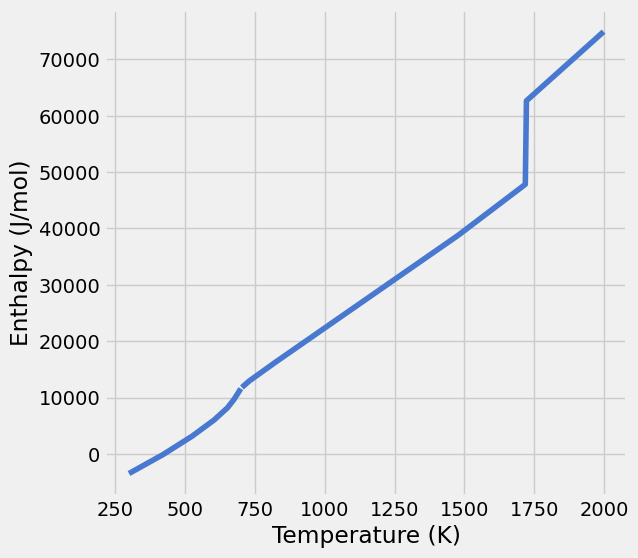

In [249]:
conditions = {
    v.P: 101325,        # Pressure in Pascals (1 atm)
    v.T: (300, 2000, 2),           # Temperature in Kelvin
    v.X('NI'): 0.47      # Mole fraction of Ni (Fe is implied as 0.5)
}
Output = ['HM']
eq = equilibrium(db, components, phases, conditions, output=Output)

# Extract data
T = eq['T'].values
Hm = np.squeeze(eq['HM'].values)

# Plot using pyplot
plt.figure(figsize=(6, 6))
plt.plot(T, Hm)

plt.xlabel('Temperature (K)')
plt.ylabel(r'Enthalpy (J/mol)')

plt.show()

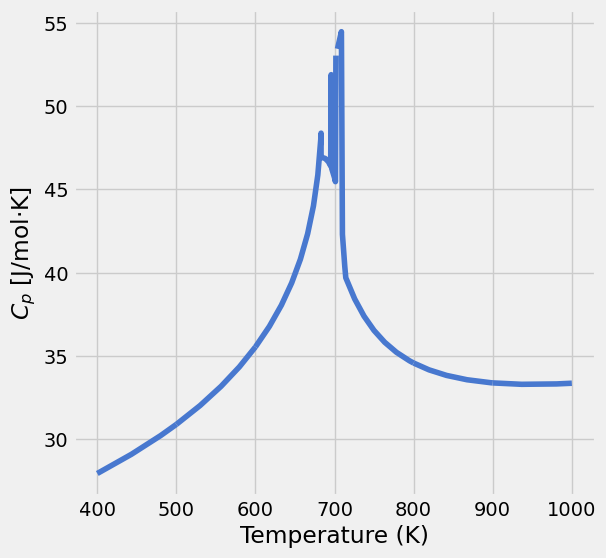

In [ ]:
conditions = {
    v.P: 101325,        # Pressure in Pascals (1 atm)
    v.T: (400, 1800, 0.05),           # Temperature in Kelvin
    v.X('NI'): 0.47      # Mole fraction of Ni (Fe is implied as 0.5)
}
Output = ['heat_capacity']
eq = equilibrium(db, components, phases, conditions, output=Output)

# Extract data
T = eq['T'].values
Cp = np.squeeze(eq['heat_capacity'].values)

# Plot using pyplot
plt.figure(figsize=(6, 6))
plt.plot(T, Cp)

plt.xlabel('Temperature (K)')
plt.ylabel(r'$C_p$ [J/mol·K]')

plt.show()

At $X_{\text{Ni}} = 0.47$, the system is **Fe-rich**, and Fe is **ferromagnetic** below its Curie temperature. In Fe–Ni alloys:
- The **Curie temperature decreases** as you add Ni up to ~30–40 at% Ni
- Around **47 at% Ni**, the Curie point is still present but **lower than that of pure Fe** (~770 K)

According to experimental data:
- At **47 at% Ni**, the Curie temperature is typically in the range of **~700–730 K**, depending on the model and exact ordering
- This aligns well with the **heat capacity peak you observed**, suggesting a magnetic transition

In `equilibrium()` or `calculate()`:
- If the thermodynamic database includes **magnetic contributions** (via the Inden model), the **magnetic entropy change** will produce a **heat capacity peak**
- This is exactly what you're seeing in your $C_p$ curve: a λ-shaped peak near ~720–730 K

Conclusion:
Yes — at $X_{\text{Ni}} = 0.47$, the sharp $C_p$ peak around 720–730 K **does correspond to a magnetic transition** (Curie point), predicted by the thermodynamic model for Fe–Ni.

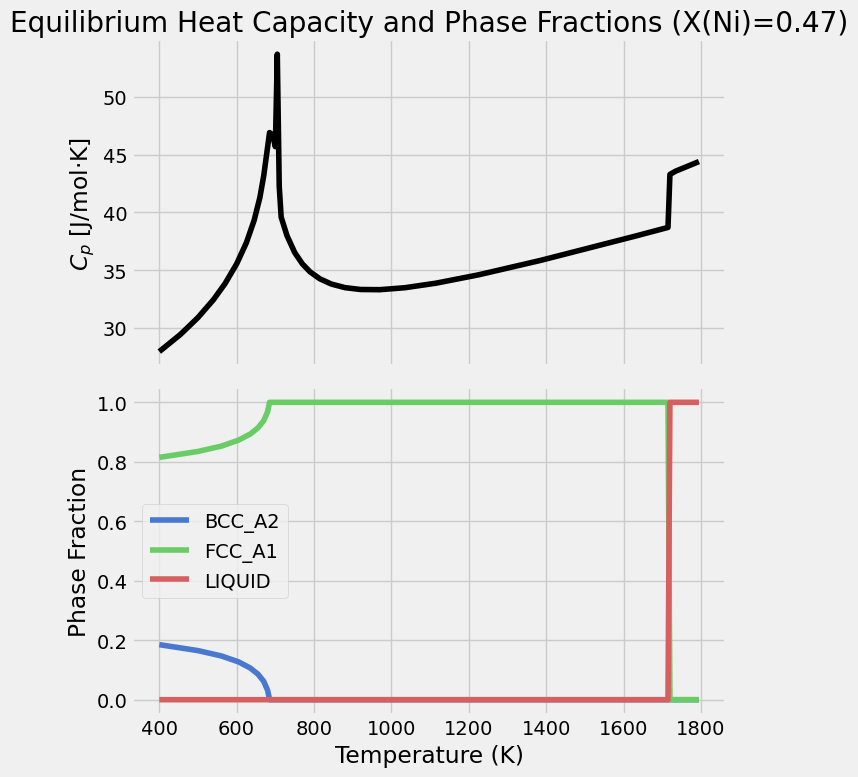

In [256]:
# Define conditions: fixed composition, temperature sweep
conditions = {
    v.P: 101325,                  # Standard pressure
    v.T: (400, 1800, 5),          # T in K, step size 5 K
    v.X('NI'): 0.47               # Fixed composition
}
outputs = ['heat_capacity']

# Run equilibrium
eq = equilibrium(db, components, phases, conditions, output=outputs)

# Extract temperature and heat capacity
T = eq['T'].values
Cp = np.squeeze(eq['heat_capacity'].values)

# Extract phase names and amounts (NP)
phase_names = eq['Phase'].values[0, 0, :, 0]  # shape: (T, vertex)
amounts = eq['NP'].values[0, 0, :, 0]         # shape: (T, vertex)

# Prepare phase-wise amount tracking
unique_phases = sorted(set(phase for row in phase_names for phase in row if phase != ''))
phase_amounts = {phase: np.zeros_like(T) for phase in unique_phases}

# Aggregate amounts per phase
for i, row in enumerate(phase_names):
    for j, phase in enumerate(row):
        if phase and not np.isnan(amounts[i, j]):
            phase_amounts[phase][i] += amounts[i, j]

# === Plotting ===

fig, axs = plt.subplots(2, 1, figsize=(7, 8), sharex=True)

# Plot Cp
axs[0].plot(T, Cp, color='black')
axs[0].set_ylabel(r'$C_p$ [J/mol·K]')
axs[0].set_title('Equilibrium Heat Capacity and Phase Fractions (X(Ni)=0.47)')
axs[0].grid(True)

# Plot phase amounts
for phase, data in phase_amounts.items():
    axs[1].plot(T, data, label=phase)

axs[1].set_xlabel('Temperature (K)')
axs[1].set_ylabel('Phase Fraction')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()